# Analysis of XRD file, including smoothing filter and fit analysis

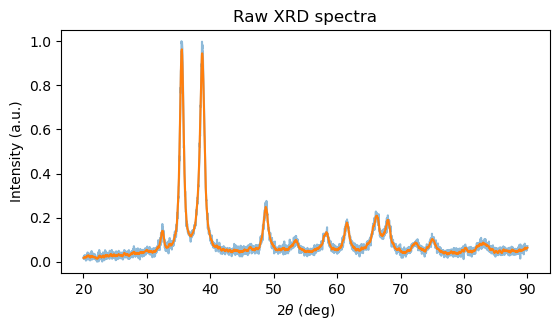

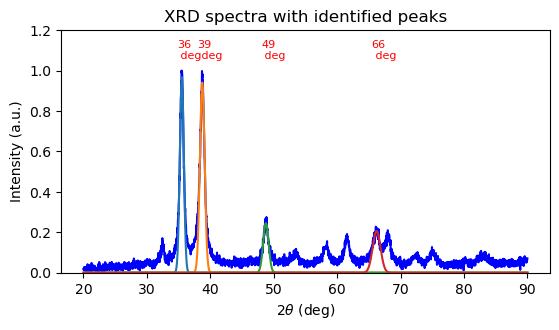

<Figure size 640x480 with 0 Axes>

In [1]:
#!/usr/bin/env python
# coding: utf-8

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from scipy.signal import savgol_filter
import math

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Functions

def cm_to_inch(cm):
    inch=float(cm/2.54)
    return inch

def AgCl_to_RHE(V_AgCl,pH,ref):
    if ref == "Ag/AgCl":
        V_RHE=+0.197+V_AgCl+0.059*pH
        return V_RHE

url_XRD = "https://raw.githubusercontent.com/FedeDat/SuPERCO2/main/data/24-10-30_CuO/characterization/XRD.csv"
    
data_XRD = pd.read_csv(url_XRD, header=None, usecols=[0, 1], names=['Angle', 'Intensity'])
    
k_XRD = float(data_XRD[data_XRD.apply(lambda row: row.astype(str).str.contains('K-Alpha1 wavelength')).any(axis=1)]['Intensity'])/10 # X-ray wavelenght

n_XRD = int(data_XRD[data_XRD.apply(lambda row: row.astype(str).str.contains('No. of points')).any(axis=1)]['Intensity'])

data_XRD_sl = data_XRD.iloc[(data_XRD[data_XRD.apply(lambda row: row.astype(str).str.contains('Angle')).any(axis=1)].index[0]+1):]

data_XRD_sl = data_XRD_sl.astype(float)

data_XRD_sl['Intensity'] = data_XRD_sl['Intensity'] - np.min(data_XRD_sl['Intensity'])

data_XRD_sl['Intensity']=data_XRD_sl['Intensity']/np.max(data_XRD_sl['Intensity'])

data_XRD_sl['Intensity_savgol'] = savgol_filter(data_XRD_sl['Intensity'], window_length=10, polyorder=1)

k_XRD = float(data_XRD[data_XRD.apply(lambda row: row.astype(str).str.contains('K-Alpha1 wavelength')).any(axis=1)]['Intensity'])/10 # X-ray wavelenght

n_XRD = int(data_XRD[data_XRD.apply(lambda row: row.astype(str).str.contains('No. of points')).any(axis=1)]['Intensity'])

data_XRD_sl = data_XRD.iloc[(data_XRD[data_XRD.apply(lambda row: row.astype(str).str.contains('Angle')).any(axis=1)].index[0]+1):]

data_XRD_sl = data_XRD_sl.astype(float)

data_XRD_sl['Intensity'] = data_XRD_sl['Intensity'] - np.min(data_XRD_sl['Intensity'])

data_XRD_sl['Intensity']=data_XRD_sl['Intensity']/np.max(data_XRD_sl['Intensity'])

data_XRD_sl['Intensity_savgol'] = savgol_filter(data_XRD_sl['Intensity'], window_length=10, polyorder=1)

plt.figure(figsize=(cm_to_inch(16), cm_to_inch(8)))

plt.plot(data_XRD_sl['Angle'],data_XRD_sl['Intensity'], label='Raw data', alpha=0.5)
plt.plot(data_XRD_sl['Angle'],data_XRD_sl['Intensity_savgol'], label='Savitzky-Golay smoothing')

plt.title('Raw XRD spectra')

plt.xlabel(r"$2{\theta}$ (deg)")

plt.ylabel('Intensity (a.u.)')

plt.savefig('XRD_spectra.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

#plt.close()

# Step 1: Identify peaks
peaks, _ = find_peaks(data_XRD_sl['Intensity_savgol'], height=0.205, distance=6)  # Adjust height threshold as needed

# Step 2: Define a Gaussian function for fitting
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-(x - mean) ** 2 / (2 * stddev ** 2))

# Step 3: Fit Gaussian to each peak
fitted_params = []

p_saved=0

for peak in peaks:

    # Define the x range for fitting (e.g., around the peak)
    x_fit = data_XRD_sl['Angle'][peak-20:peak+20]
    y_fit = data_XRD_sl['Intensity'][peak-20:peak+20]

    # Fit Gaussian
    initial_guess = [1, data_XRD_sl['Angle'][peak], 0.3]  # Initial guesses for amplitude, mean, and stddev
    try:
        params, _ = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess)
        fitted_params.append(params)
    except RuntimeError:
        print(f"Fit failed for peak at index {peak}")

# Step 4: Plot the data, peaks, and fitted Gaussian

plt.figure(figsize=(cm_to_inch(16), cm_to_inch(8)))

plt.plot(data_XRD_sl['Angle'], data_XRD_sl['Intensity'], color='blue')

# Plot Gaussian fits
for params in fitted_params:
    amp, mean, stddev = params
    plt.plot(data_XRD_sl['Angle'], gaussian(data_XRD_sl['Angle'], amp, mean, stddev))

n_peak=0

scherrer=pd.DataFrame(index=range(len(peaks)),columns=['Peak position (deg)','Crystallite size (nm)'])

for peak in peaks:

    scherrer.iloc[n_peak,0]=fitted_params[n_peak][1]
    scherrer.iloc[n_peak,1]=k_XRD*np.cos(math.radians(fitted_params[n_peak][1]/2))/(2*np.sqrt(2*np.log(2))*math.radians(fitted_params[n_peak][2]))

    plt.text(data_XRD_sl['Angle'][peak], 1.1, f'{fitted_params[n_peak][1]:.0f}'+'\n deg', va='center', fontsize=8, color="red")

    n_peak=n_peak+1

plt.title('XRD spectra with identified peaks')

plt.xlabel(r"$2{\theta}$ (deg)")

plt.ylabel('Intensity (a.u.)')

plt.ylim(0, 1.2)

plt.show()

scherrer.to_csv('XRD_fit.csv', index=False)
plt.savefig('XRD_spectra_fitted.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

#plt.close()

In [3]:
scherrer

,Peak position (deg),Crystallite size (nm)
0,35.503403,11.380922
1,38.727627,9.507698
2,48.761878,7.952307
3,66.217557,5.060453
